In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP, running_mean_APWP_shape, RM_stats, get_pseudo_vgps,
                                  running_mean_VGPs_bootstrapped, running_mean_bootstrapping_direction)

from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, PC
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(current_path +'/data/df_pole_compilation_by_study.csv')

## Set the hyperparameters for further comparissons.

In [6]:
min_age = 0
max_age = 65
window_length = 20
time_step = 2
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [5]:
RM_1_classic = running_mean_APWP (df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic['method'] = "RM_classic"
models.append(RM_1_classic)
RM_1_classic.head(5)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
1,10.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
2,20.0,4.0,4.0,694.396487,3.489190,3.073840,-15.989200,-81.836813,RM_classic
3,30.0,7.0,7.0,460.397603,2.816323,3.775013,-28.128989,-82.900850,RM_classic
4,40.0,8.0,8.0,254.364022,3.479776,5.078754,-28.898450,-83.239212,RM_classic


### 2. Running means ensemble from pseudo-VGPs approach (Vaes et al. 2022)

In [7]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i

    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)
RM_2_ensemble_pseudoVGP['plon'] = RM_2_ensemble_pseudoVGP.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    
RM_2_ensemble_pseudoVGP['method'] = "RM_pseudoVGPs_ensemble"
models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 48.5 s, sys: 218 ms, total: 48.7 s
Wall time: 48.7 s


Set quantiles

In [8]:
RM_2_quantiles_plat = quantiles(RM_2_ensemble_pseudoVGP,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_2_quantiles_plon = quantiles(RM_2_ensemble_pseudoVGP,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_2_ensemble_pseudoVGP.head(3)

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,GCD,APW_rate,angle,method
0,0,15.0,23.771238,1.659824,16.613423,0.0,315.0,-50.056609,-87.161501,0.099746,0.788208,7.902175,0.887954,NaN,NaN,NaN,RM_pseudoVGPs_ensemble
1,0,15.0,23.985074,1.618864,16.5392,2.0,328.0,-48.759449,-87.269952,0.095148,0.789994,8.302781,0.885142,0.125420,0.062710,177.871955,RM_pseudoVGPs_ensemble
2,0,15.0,24.018298,1.593478,16.527756,4.0,338.0,-47.333592,-87.370127,0.070144,0.783292,11.166945,0.853436,0.120325,0.060163,77.479034,RM_pseudoVGPs_ensemble


## 3. Running means on VGPs. 
Three different approachs as follows:
### 3.1. Running means on the computed dataset (one run and A95)

In [9]:
RM_31_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_31_on_VGP['method'] = "RM_classic_VGPs"
models.append(RM_31_on_VGP)

In [10]:
RM_31_on_VGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,305.0,15.0,23.294563,1.704883,16.782542,-42.916770,-87.945102,RM_classic_VGPs
1,2.0,308.0,15.0,22.847346,1.713794,16.945998,-45.430085,-88.076649,RM_classic_VGPs
2,4.0,309.0,15.0,22.671004,1.717952,17.011775,-45.363582,-87.974789,RM_classic_VGPs


### 3.2. Running means on random samples (with replacement) from the original dataset to generate an ensemble of possible solution.

In [11]:
%%time
RM_32_boots_VGPs=running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_32_boots_VGPs['method']="RM_bootstrapped_VGPs_ensemble"
models.append(RM_32_boots_VGPs)

CPU times: user 30.7 s, sys: 111 ms, total: 30.8 s
Wall time: 30.8 s


Set quantiles

In [12]:
RM_32_quantiles_plat = quantiles(RM_32_boots_VGPs,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_32_quantiles_plon = quantiles(RM_32_boots_VGPs,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_32_boots_VGPs.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,GCD,APW_rate,angle,method
0,0.0,341.0,24.5634,1.567967,16.343339,0.188209,0.723219,3.842632,0.911428,0.0,15.0,-104.195237,-89.094830,NaN,NaN,NaN,RM_bootstrapped_VGPs_ensemble
1,0.0,346.0,23.760084,1.583776,16.617322,0.197945,0.708025,3.576881,0.90597,2.0,15.0,-122.465693,-89.047866,0.298486,0.149243,NaN,RM_bootstrapped_VGPs_ensemble
2,0.0,346.0,23.760084,1.583776,16.617322,0.197945,0.708025,3.576881,0.90597,4.0,15.0,-122.465693,-89.047866,0.000000,0.000000,NaN,RM_bootstrapped_VGPs_ensemble


### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [13]:
%%time
RM_33_propagation=running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_33_propagation['method']="RM_DirErrorPropagated_ensemble"
models.append(RM_33_propagation)

CPU times: user 1min 1s, sys: 135 ms, total: 1min 1s
Wall time: 1min 1s


Set quantiles

In [14]:
RM_33_quantiles_plat = quantiles(RM_33_propagation,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_33_quantiles_plon = quantiles(RM_33_propagation,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_33_propagation.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,GCD,APW_rate,angle,method
0,0.0,309.0,18.149466,1.931172,19.013107,0.051792,0.664706,12.834197,0.716498,0.0,15.0,-31.326308,-87.044732,NaN,NaN,NaN,RM_DirErrorPropagated_ensemble
1,0.0,310.0,17.881853,1.94326,19.15485,0.049904,0.664968,13.324879,0.714872,2.0,15.0,-31.258511,-87.186513,0.141823,0.070911,4.125393,RM_DirErrorPropagated_ensemble
2,0.0,311.0,17.717835,1.949612,19.243306,0.049764,0.671242,13.488453,0.721006,4.0,15.0,-31.487436,-87.065614,0.121443,0.060721,166.769205,RM_DirErrorPropagated_ensemble


## Get APW from Muller et al., 2016 and Torsvik and Cocks, 2017

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211
- Torsvik, T. H., & Cocks, L. R. M. (2013). Gondwana from top to base in space and time. Gondwana Research, 24(3-4), 999-1030.


In [15]:
Torsvik2017_path = np.loadtxt('model_APWP/code_output/NAM_0_60_torsvik_2017.txt', )
Torsvik2017_path_df = pd.DataFrame(Torsvik2017_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Torsvik2017_path_df = Torsvik2017_path_df[Torsvik2017_path_df['age']>0]
Torsvik2017_path_df['method'] = "plate model"
models.append(Torsvik2017_path_df)

Mueller2016_path = np.loadtxt('model_APWP/code_output/NAM_0_60_muller_2016.txt', )
Mueller2016_path_df = pd.DataFrame(Mueller2016_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Mueller2016_path_df = Mueller2016_path_df[Mueller2016_path_df['age']>0]
Mueller2016_path_df['method']="plate model"
models.append(Mueller2016_path_df)

Merge

In [16]:
df_all = pd.concat(models, axis=0)
df_all.head()

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,GCD,APW_rate,angle,method,Euler_angle,Euler_lon,Euler_lat
0,0,15.0,23.771238,1.659824,16.613423,0.0,315.0,-50.056609,-87.161501,0.099746,0.788208,7.902175,0.887954,NaN,NaN,NaN,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
1,0,15.0,23.985074,1.618864,16.5392,2.0,328.0,-48.759449,-87.269952,0.095148,0.789994,8.302781,0.885142,0.125420,0.062710,177.871955,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
2,0,15.0,24.018298,1.593478,16.527756,4.0,338.0,-47.333592,-87.370127,0.070144,0.783292,11.166945,0.853436,0.120325,0.060163,77.479034,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
3,0,16.0,24.0261,1.545709,16.525073,6.0,359.0,-44.442964,-87.216771,0.091397,0.775079,8.480323,0.866477,0.205258,0.102629,171.346602,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
4,0,17.0,21.812417,1.590628,17.343356,8.0,375.0,-40.570209,-86.865390,0.034497,0.788156,22.846978,0.822653,0.404075,0.202038,158.978787,RM_pseudoVGPs_ensemble,NaN,NaN,NaN


# Comparisons plot

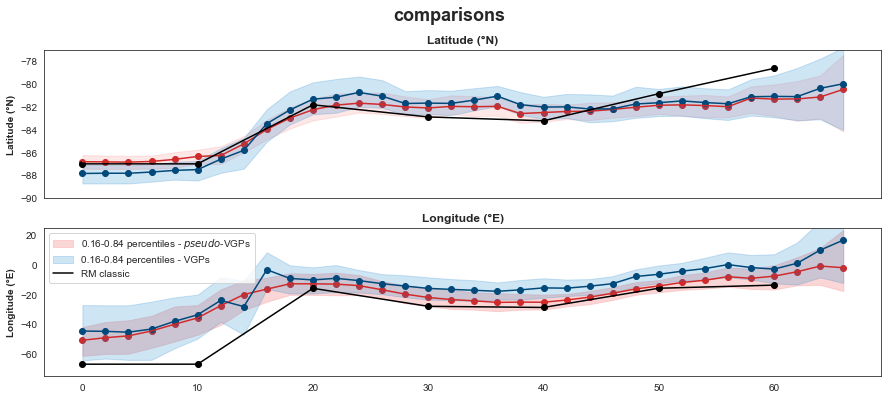

In [20]:
title = "comparisons"

df_method1=RM_2_ensemble_pseudoVGP
df_method2=RM_33_propagation

ensemble1_lat = quantiles(df_method1,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble1_lon = quantiles(df_method1,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
ensemble2_lat = quantiles(df_method2,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble2_lon = quantiles(df_method2,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-77)
axes[1].set_ylim(-75,25)
# LATITUDE
axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q16,ensemble1_lat.q84, color= "#f98787", alpha=.20)
axes[0].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")
axes[0].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")

axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q16,ensemble2_lat.q84, color= "#0E7DC9", alpha=.20)
axes[0].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")
axes[0].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")

axes[0].plot(RM_1_classic.age, RM_1_classic.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic.age, RM_1_classic.plat, color="black") #CLASSIC


# # LONGITUDE
axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q16,ensemble1_lon.q84, color= "#f9afaf", alpha=.50,label="0.16-0.84 percentiles - $pseudo$-VGPs")
axes[1].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0], '-',color="#d12a2a")
axes[1].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0],color="#d12a2a")

axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q16,ensemble2_lon.q84, color= "#0E7DC9", alpha=.20,label="0.16-0.84 percentiles - VGPs")
axes[1].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0], '-',color="#00497A")
axes[1].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0],color="#00497A")
axes[1].plot(RM_1_classic.age, RM_1_classic.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic.age, RM_1_classic.plon, color="black") #CLASSIC

plt.legend(loc="upper left")

# Misfit vs the Classical apporach

# APWPs vs Plate Models Visualizations

In [ ]:
title = "Comparing against plate models (M2016 and T&C2017)"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE

axes[0].plot(Mueller2016_path_df.age, Mueller2016_path_df.plat, '-',color="#d12a2a")
# axes[0].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plat,s = 1, color="#d12a2a")
axes[0].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, '-',color="#00497A") #CLASSIC
# axes[0].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, color="#00497A") #CLASSIC
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="black")
# LONGITUDE

axes[1].plot(Mueller2016_path_df.age, Mueller2016_path_df.plon, '-',color="#d12a2a", label = "Muller2016")
# axes[1].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plon,color="#d12a2a")
axes[1].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, '-',color="#00497A", label = "T&C2017") #CLASSIC
# axes[1].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, color="#00497A") #CLASSIC
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,color="black")

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")